# Neural Network Experiments with PyTorch

In [2]:
%matplotlib inline

from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [230]:
df_fires = pd.read_csv('df_fire_sample.csv')
df_fires.fire_size_class = df_fires.fire_size_class.fillna('')

df_fires_encoded = pd.get_dummies(df_fires.drop(['fire_size_class'], axis=1), columns=['month'])
scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.fire_size_class > ''

num_fires = (y == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie unbalanced)')

X_train_unbal, X_test, y_train_unbal, y_test = train_test_split(X, y, random_state=42)
print(f'X_train_unbal: {len(X_train_unbal)}, X_test: {len(X_test)}, y_train_unbal: {len(y_train_unbal)}, y_test: {len(y_test)}')

print('---- BALANCING ----')

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train_unbal, y_train_unbal)

num_fires = (y_train == True).sum()
num_data_pt = len(y_train)
print(f'Train data: no fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie balanced)')
num_fires = (y_test == True).sum()
num_data_pt = len(y_test)
print(f'Test data: no fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie unbalanced)')
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}')

/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


16597 fires out of 116597 data points
No fires 86.0% of the time (ie unbalanced)
X_train_unbal: 87447, X_test: 29150, y_train_unbal: 87447, y_test: 29150
---- BALANCING ----
Train data: no fires 50.0% of the time (ie balanced)
Test data: no fires 86.0% of the time (ie unbalanced)
X_train: 149898, X_test: 29150, y_train: 149898, y_test: 29150


## PyTorch

In [231]:
from torch.utils.data import TensorDataset
features_train = torch.from_numpy(X_train).float()
labels_train = torch.from_numpy(y_train.to_numpy()).long()
train_ds = TensorDataset(features_train, labels_train)

print(f'Train DS: {train_ds.tensors[0].size()}')

features_test = torch.from_numpy(X_test).float()
labels_test = torch.from_numpy(y_test.to_numpy()).long()
test_ds = TensorDataset(features_test, labels_test)

print(f'Test DS: {test_ds.tensors[0].size()}')

Train DS: torch.Size([149898, 68])
Test DS: torch.Size([29150, 68])


In [232]:
from torch.utils.data import DataLoader

batch_size = 200
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size)

In [233]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [234]:
def evaluate(model, valation_dl):
    outputs = [model.validation_step(batch) for batch in valation_dl]
    return model.validation_epoch_end(outputs)

In [235]:
class LogisticModel(nn.Module):
    def __init__(self, feature_count, label_count):
        super().__init__()
        self.linear = nn.Linear(feature_count, label_count)

    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        features, labels = batch 
        out = self(features)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = self(features)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return { 'loss': loss, 'accuracy': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return { 'loss': epoch_loss.item(), 'accuracy': epoch_acc.item() }
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, accuracy: {:.4f}".format(epoch, result['loss'], result['accuracy']))

In [236]:
def fit(epochs, lr, model, train_dl, test_dl, opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):
        # Training Phase 
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, test_dl)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [237]:
feature_count = features_train.size()[-1]
model = LogisticModel(feature_count, 2)
history = fit(20, 0.005, model, train_dl, test_dl, torch.optim.SGD)

Epoch [0], loss: 0.4060, accuracy: 0.8285
Epoch [1], loss: 0.3508, accuracy: 0.8590
Epoch [2], loss: 0.3300, accuracy: 0.8683
Epoch [3], loss: 0.3208, accuracy: 0.8724
Epoch [4], loss: 0.3159, accuracy: 0.8734
Epoch [5], loss: 0.3124, accuracy: 0.8749
Epoch [6], loss: 0.3096, accuracy: 0.8761
Epoch [7], loss: 0.3091, accuracy: 0.8756
Epoch [8], loss: 0.3078, accuracy: 0.8766
Epoch [9], loss: 0.3053, accuracy: 0.8784
Epoch [10], loss: 0.3067, accuracy: 0.8769
Epoch [11], loss: 0.3044, accuracy: 0.8793
Epoch [12], loss: 0.3039, accuracy: 0.8793
Epoch [13], loss: 0.3064, accuracy: 0.8766
Epoch [14], loss: 0.3065, accuracy: 0.8768
Epoch [15], loss: 0.3032, accuracy: 0.8794
Epoch [16], loss: 0.3052, accuracy: 0.8780
Epoch [17], loss: 0.3045, accuracy: 0.8784
Epoch [18], loss: 0.3047, accuracy: 0.8786
Epoch [19], loss: 0.3047, accuracy: 0.8789


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

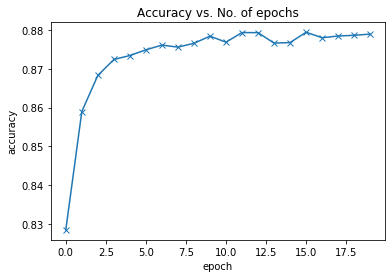

In [238]:
accuracies = [result['accuracy'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [239]:
class BinaryModel(nn.Module):
    def __init__(self, feature_count, dropout, hidden_size = 64):
        super(BinaryModel, self).__init__()
        self.layer1 = nn.Linear(feature_count, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer_out = nn.Linear(hidden_size, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size)

    def forward(self, xb):
        out = self.relu(self.layer1(xb))
        out = self.batchnorm1(out)
        out = self.relu(self.layer2(out))
        out = self.batchnorm2(out)
        out = self.dropout(out)
        out = self.layer_out(out)
        return out

    def training_step(self, batch):
        features, labels = batch 
        out = self(features)
        out = torch.squeeze(out)
        loss = F.binary_cross_entropy_with_logits(out, labels.float())
        return loss
    
    def validation_step(self, batch):
        features, labels = batch
        out = self(features)
        out = torch.squeeze(out)
        pred = torch.round(torch.sigmoid(out))
        tp = (pred * labels).sum().float()
        fn = (labels * (1 - pred)).sum().float()
        recall = tp / (tp + fn)

        loss = F.binary_cross_entropy_with_logits(out, labels.float())

        return { 'loss': loss, 'recall': recall }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_recalls = [x['recall'] for x in outputs]
        epoch_recall = torch.stack(batch_recalls).mean()
        return { 'loss': epoch_loss.item(), 'recall': epoch_recall.item() }
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, recall: {:.4f}".format(epoch, result['loss'], result['recall']))

In [240]:
dropout = 0.1
model = BinaryModel(feature_count, dropout)
history = fit(15, 0.001, model, train_dl, test_dl)

Epoch [0], loss: 0.7245, recall: 0.9713
Epoch [1], loss: 0.7253, recall: 0.9791
Epoch [2], loss: 0.6800, recall: 0.9815
Epoch [3], loss: 0.6612, recall: 0.9818
Epoch [4], loss: 0.6811, recall: 0.9841
Epoch [5], loss: 0.6993, recall: 0.9807
Epoch [6], loss: 0.6313, recall: 0.9793
Epoch [7], loss: 0.6744, recall: 0.9837
Epoch [8], loss: 0.6177, recall: 0.9818
Epoch [9], loss: 0.6065, recall: 0.9806
Epoch [10], loss: 0.6139, recall: 0.9765
Epoch [11], loss: 0.6448, recall: 0.9793
Epoch [12], loss: 0.6109, recall: 0.9783
Epoch [13], loss: 0.5491, recall: 0.9761
Epoch [14], loss: 0.6324, recall: 0.9786


Text(0.5, 1.0, 'Recall vs. No. of epochs')

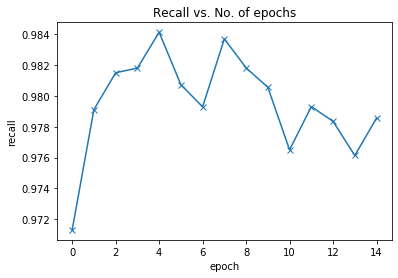

In [241]:
accuracies = [result['recall'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('recall')
plt.title('Recall vs. No. of epochs')